# A simple neural network

Neural networks are amazing. When used well, they seem simulate intellegent behavior to accomplish a wide variety of tasks ranging from image recognition to image generation, from language comprehension to language translation, and much more. The thing about neural networks, though, is that they are typically designed with a specific task in mind. 

Clever people have been spent a lot of time trying to discover ways to implement neural networks in order to optimize for specific tasks. This has lead to the discovery of a wide diversity of architectures that tend to be suited for their specific tasks. You may be familiar with some of these architectures. One such artchitecture is the convolutional nerual network (ConvNet). Another is the recurrent neural network (RNN). ConvNets tend to be suited for image recognition tasks, whereas RNNs tend to perform well on sequence based tasks, such as language processing.

The simplest kind of neural network is called a feed forward network, which is what we'll focus on in this notebook. When you break down some of the more advanced architectures, it becomes apparent that they are basically just clever ways to combine various feed forward networks that use the same mathematical operations we'll learn about by building a feed forward network. For example, the LSTM architecture uses a system of feed forward networks to gate information as it passes through the network.

So using our understanding of vector and matrix operations, lets implement a feed forward network from scratch using numpy!

### The feed forward network 

Any neural network needs to be designed around a task. In the previous session we talked about some of the mathematical operations that occur inside a feed forward network, but haven't talked about any of the operations that happen on either end.

On the input end, we typically need to consider getting our data cleaned and organized in such a way that that we can feed it in as a vector. On the other end, we need to pose the learning task in the form of a loss function, the goal that we are optimizing for.

We will use a standard dataset that does not require much preprocessing and we'll choose a simple loss function that doesn't require much work to understand for now. We can focus on these things in a later session. Input preprocessing tends to be different for each network you create, and loss functions will be discussed when we cover the the training process in greater depth.

How can we implement a feed forward network without understanding how to train it? We can't! We'll gloss over backpropogation in this session and save that for the next session.

#### Imports

In [1]:
import numpy as np
from sklearn.datasets import load_boston
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns



#### Load the dataset

For this network, we'll use the boston housing dataset. The goal for this dataset is to learn a model that helps us predict the median market value of the house based on features gathered assocated with the property. This is idea for a simple neural network since we want to use a simple loss function. Since we're predicting a price, we can frame this as a regression problem and use a sum of squares loss function.

In [2]:
boston = load_boston(return_X_y=False)

In [3]:
print(boston.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

#### Visualize the data

In [4]:
boston.data

array([[6.3200e-03, 1.8000e+01, 2.3100e+00, ..., 1.5300e+01, 3.9690e+02,
        4.9800e+00],
       [2.7310e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9690e+02,
        9.1400e+00],
       [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9283e+02,
        4.0300e+00],
       ...,
       [6.0760e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        5.6400e+00],
       [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9345e+02,
        6.4800e+00],
       [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        7.8800e+00]])

In [5]:
boston.target

array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9, 15. ,
       18.9, 21.7, 20.4, 18.2, 19.9, 23.1, 17.5, 20.2, 18.2, 13.6, 19.6,
       15.2, 14.5, 15.6, 13.9, 16.6, 14.8, 18.4, 21. , 12.7, 14.5, 13.2,
       13.1, 13.5, 18.9, 20. , 21. , 24.7, 30.8, 34.9, 26.6, 25.3, 24.7,
       21.2, 19.3, 20. , 16.6, 14.4, 19.4, 19.7, 20.5, 25. , 23.4, 18.9,
       35.4, 24.7, 31.6, 23.3, 19.6, 18.7, 16. , 22.2, 25. , 33. , 23.5,
       19.4, 22. , 17.4, 20.9, 24.2, 21.7, 22.8, 23.4, 24.1, 21.4, 20. ,
       20.8, 21.2, 20.3, 28. , 23.9, 24.8, 22.9, 23.9, 26.6, 22.5, 22.2,
       23.6, 28.7, 22.6, 22. , 22.9, 25. , 20.6, 28.4, 21.4, 38.7, 43.8,
       33.2, 27.5, 26.5, 18.6, 19.3, 20.1, 19.5, 19.5, 20.4, 19.8, 19.4,
       21.7, 22.8, 18.8, 18.7, 18.5, 18.3, 21.2, 19.2, 20.4, 19.3, 22. ,
       20.3, 20.5, 17.3, 18.8, 21.4, 15.7, 16.2, 18. , 14.3, 19.2, 19.6,
       23. , 18.4, 15.6, 18.1, 17.4, 17.1, 13.3, 17.8, 14. , 14.4, 13.4,
       15.6, 11.8, 13.8, 15.6, 14.6, 17.8, 15.4, 21

In [6]:
df = pd.DataFrame(boston.data, columns=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX',
                                        'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO',
                                        'B', 'LSTAT'])
df.loc[:, 'target'] = boston.target
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


With any dataset, there is the opportunity to explore the data to find feature that are going to likely be the most helpful when training the model. This is the case for any model and it is generally recommended. Since we're focusing on the network implementation, we'll skip the data exploration for now. 

#### Define a data batcher
When we send data through the network, we can send samples through one at a time or in batches. So its useful to have a function that handle that for us.

In [8]:
def data_batcher(inputs, targets, batch_size=5):
    assert len(inputs) == len(targets)
    
    inputs = inputs[: -(len(inputs) % batch_size)].reshape(-1, batch_size, inputs.shape[1])
    targets = targets[: -(len(targets) % batch_size)].reshape(-1, batch_size)
    
    batched_data = list()
    for x_inputs, y_targets in zip(inputs, targets):
        batched_data.append([x_inputs, y_targets.reshape(-1, 1)])
    
    return batched_data

#### Define a loss function

In [25]:
def loss_function(pred, targ):
    return 0.5 * np.sum((targ - pred)**2)

In [26]:
def loss_function_deriv(pred, targ):
    return (targ - pred)

### Implement a linear network

In [52]:
# Set how many times to iterate through the dataset
epochs = 50000

# Set hyperparamters
lr = 0.00001
batch_size = 5

#Set dimensions of hidden layer
input_size = 13
hidden_size = 10

samples_seen = 0

# Set learnable weight matrices
hidden_weights = np.random.normal(loc=0.0, scale=0.01, size=(13, 10))
output_weights = np.random.normal(loc=0.0, scale=0.01, size=(10, 1))  # a single output!

# Train the network
for each_epoch in range(epochs):
    
    #create
    batched_data = data_batcher(boston.data, boston.target, batch_size=batch_size)
    epoch_loss = 0
    
    for batch_input, batch_target in batched_data:

        samples_seen += 1 * batch_size

        # Forward Pass
        hidden_layer_out = np.dot(batch_input, hidden_weights) # No activation function
        pred = np.dot(hidden_layer_out, output_weights) # No activation function

        # loss
        epoch_loss += loss_function(pred, batch_target)

        # backprop
        l2delta = loss_function_deriv(pred, batch_target) # No derivative
        l1delta = np.dot(l2delta, output_weights.T)  # No derivative since no nonlinear activation!

        # gradient descent
        output_weights += np.dot(hidden_layer_out.T, l2delta) * lr
        hidden_weights += np.dot(batch_input.T, l1delta) * lr

    if each_epoch % 5000 == 0:
        print("epoch {} ... loss: {} ... samples seen: {}".format(each_epoch, round(epoch_loss, 2), samples_seen))


epoch 0 ... loss: 24280.97
epoch 5000 ... loss: 8906.51
epoch 10000 ... loss: 7962.93
epoch 15000 ... loss: 7563.06
epoch 20000 ... loss: 7344.25
epoch 25000 ... loss: 7211.22
epoch 30000 ... loss: 7128.51
epoch 35000 ... loss: 7095.37
epoch 40000 ... loss: 7108.56
epoch 45000 ... loss: 7117.18


## Implement a non-linear network

In [54]:
def sigmoid(x):  # Non-linearity
    return 1. / (1 + np.exp(-x))

def sigmoid_deriv(x):
    return x * (1. - x)

In [56]:
# Set how many times to iterate through the dataset
epochs = 50000

# Set hyperparamters
lr = 0.00001
batch_size = 5

#Set dimensions of hidden layer
input_size = 13
hidden_size = 10

# Set learnable weight matrices
hidden_weights = np.random.normal(loc=0.0, scale=0.01, size=(13, 10))
output_weights = np.random.normal(loc=0.0, scale=0.01, size=(10, 1))  # a single output!

samples_seen = 0
# Train the network
for each_epoch in range(epochs):
    
    #create
    batched_data = data_batcher(boston.data, boston.target, batch_size=batch_size)
    epoch_loss = 0
    
    for batch_input, batch_target in batched_data:
        samples_seen += 1 * batch_size
        
        # Forward pass
        hidden_layer_out = sigmoid(np.dot(batch_input, hidden_weights))
        pred = np.dot(hidden_layer_out, output_weights) # No activation function

        # loss
        epoch_loss += loss_function(pred, batch_target)

        # backprop
        l2delta = loss_function_deriv(pred, batch_target) * 1
        l1delta = np.dot(l2delta, output_weights.T)  * sigmoid_deriv(hidden_layer_out)

        # gradient descent
        output_weights += np.dot(hidden_layer_out.T, l2delta) * lr
        hidden_weights += np.dot(batch_input.T, l1delta) * lr

    if each_epoch % 5000 == 0:
        print("epoch {} ... loss: {} ... samples seen: {}".format(each_epoch, round(epoch_loss, 2), samples_seen))


epoch 0 ... loss: 145977.46 ... samples seen: 505
epoch 5000 ... loss: 19464.9 ... samples seen: 2525505
epoch 10000 ... loss: 19353.07 ... samples seen: 5050505
epoch 15000 ... loss: 19347.6 ... samples seen: 7575505
epoch 20000 ... loss: 17468.07 ... samples seen: 10100505
epoch 25000 ... loss: 19329.32 ... samples seen: 12625505
epoch 30000 ... loss: 19334.11 ... samples seen: 15150505
epoch 35000 ... loss: 19333.33 ... samples seen: 17675505
epoch 40000 ... loss: 19332.69 ... samples seen: 20200505
epoch 45000 ... loss: 19332.16 ... samples seen: 22725505


#### Create a layer class and do it again

In [92]:
class Layer(object):
    
    def __init__(self, 
                 input_dim,
                 output_dim,
                 learning_rate,
                 name,
                 activation=None):

        self.weights = np.random.normal(0.0, 0.01, (input_dim, output_dim))
        self.name = name
        self.learning_rate = learning_rate
        self.input_dim = input_dim
        self.output_dim = output_dim

        activations = {'sigmoid': self.sigmoid,
                       'relu': self.relu,
                        None: self.non_activation}

        derivs = {'sigmoid': self.sigmoid_deriv,
                  'relu': self.relu_driv,
                   None: self.non_activation_deriv}


        self.activation = activations[activation]
        self.activation_deriv = derivs[activation]

    def forward_pass(self, input_x):
        self.input = input_x
        self.output = self.activation(np.dot(self.input, self.weights))
        return self.output

    def backward_pass(self, output_delta):
        self.weight_output_delta = output_delta * self.activation_deriv(self.output)
        return np.dot(self.weight_output_delta, self.weights.T)

    def update_weights(self):
        self.weights += np.dot(self.input.T, self.weight_output_delta) * self.learning_rate

    def sigmoid(self, x):
        return 1. / (1 + np.exp(-x))

    def sigmoid_deriv(self, x):
        return x * (1. - x)
    
    def non_activation(self, x):
        return x
    
    def non_activation_deriv(self, x):
        return 1
    
    def relu(self, x):
        return 0 if x <= 0 else x
    
    def relu_deriv(self, x):
        return 1

In [91]:
# Set how many times to iterate through the dataset
epochs = 50000

# Set hyperparamters
lr = 0.00001
batch_size = 5


# init layers
hidden_layer = Layer(input_dim=13, output_dim=10, learning_rate=lr, name='hidden_layer')
output_layer = Layer(input_dim=10, output_dim=1, learning_rate=lr, name='output_layer')

samples_seen = 0

# Train the network
for each_epoch in range(epochs):

    #create batches
    batched_data = data_batcher(boston.data, boston.target, batch_size=batch_size)

    epoch_loss = 0
    for batch_input, batch_target in batched_data:
        samples_seen += 1 * batch_size

        # Forward pass
        hidden_out = hidden_layer.forward_pass(batch_input)
        pred = output_layer.forward_pass(hidden_out)

        # loss
        epoch_loss += loss_function(pred, batch_target)

        # backprop
        output_delta = loss_function_deriv(pred, batch_target)
        hidden_delta = output_layer.backward_pass(output_delta)
        hidden_layer.backward_pass(hidden_delta)

        # gradient descent
        output_layer.update_weights()
        hidden_layer.update_weights()

    if each_epoch % 5000 == 0:
        print("epoch {} ... loss: {} ... samples seen: {}".format(each_epoch, round(epoch_loss, 2), samples_seen))


epoch 0 ... loss: 23522.85 ... samples seen: 505
epoch 5000 ... loss: 8906.18 ... samples seen: 2525505
epoch 10000 ... loss: 7962.73 ... samples seen: 5050505
epoch 15000 ... loss: 7562.94 ... samples seen: 7575505
epoch 20000 ... loss: 7344.18 ... samples seen: 10100505
epoch 25000 ... loss: 7211.16 ... samples seen: 12625505
epoch 30000 ... loss: 7128.46 ... samples seen: 15150505
epoch 35000 ... loss: 7097.43 ... samples seen: 17675505
epoch 40000 ... loss: 7108.94 ... samples seen: 20200505
epoch 45000 ... loss: 7116.5 ... samples seen: 22725505


/Users/pgradie/miniconda-3.9.1/envs/py3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


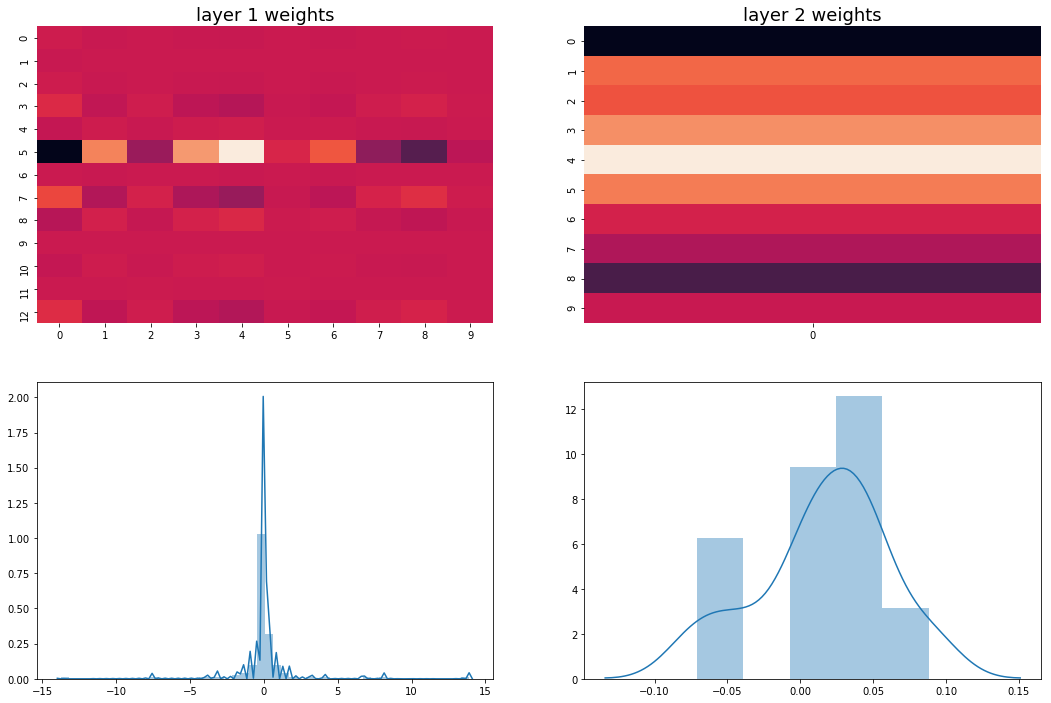

In [93]:
layers = [hidden_layer.weights, output_layer.weights,
          hidden_layer.weights.flatten(), output_layer.weights.flatten()]

fig, axs = plt.subplots(figsize=(18, 12), nrows=2, ncols=2)
bar = False
for ix, (layer, ax) in enumerate(zip(layers, axs.flatten())):
    if ix < 2:
        if ix == 2:
            bar = True
        sns.heatmap(layer, ax=ax, cbar=bar)
        ax.set_title('layer {} weights'.format(ix+1), fontdict={'fontsize': 18})
    else:
        sns.distplot(layer, ax=ax);